In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 머신러닝
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

In [2]:
rawData = pd.read_csv('./data/london_merged.csv')

In [3]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [4]:
rawData.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [5]:
rawData.weather_code.unique()

array([ 3.,  1.,  4.,  7.,  2., 26., 10.])

In [6]:
rawData.is_holiday.unique()

array([0., 1.])

In [7]:
rawData.is_weekend.unique()

array([1., 0.])

In [8]:
rawData.season.unique()

array([3., 0., 1., 2.])

In [9]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [10]:
rawData['timestamp'] = pd.to_datetime(rawData['timestamp'])

In [11]:
rawData['datetime'] = rawData['timestamp']

In [12]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,datetime
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04 03:00:00
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017-01-03 19:00:00
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017-01-03 20:00:00
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017-01-03 21:00:00
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017-01-03 22:00:00


In [13]:
rawData.set_index('datetime', inplace=True)

In [14]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
datetime,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [15]:
rawData.index

DatetimeIndex(['2015-01-04 00:00:00', '2015-01-04 01:00:00',
               '2015-01-04 02:00:00', '2015-01-04 03:00:00',
               '2015-01-04 04:00:00', '2015-01-04 05:00:00',
               '2015-01-04 06:00:00', '2015-01-04 07:00:00',
               '2015-01-04 08:00:00', '2015-01-04 09:00:00',
               ...
               '2017-01-03 14:00:00', '2017-01-03 15:00:00',
               '2017-01-03 16:00:00', '2017-01-03 17:00:00',
               '2017-01-03 18:00:00', '2017-01-03 19:00:00',
               '2017-01-03 20:00:00', '2017-01-03 21:00:00',
               '2017-01-03 22:00:00', '2017-01-03 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17414, freq=None)

In [16]:
rawData = rawData.asfreq('H')

In [17]:
rawData.index

DatetimeIndex(['2015-01-04 00:00:00', '2015-01-04 01:00:00',
               '2015-01-04 02:00:00', '2015-01-04 03:00:00',
               '2015-01-04 04:00:00', '2015-01-04 05:00:00',
               '2015-01-04 06:00:00', '2015-01-04 07:00:00',
               '2015-01-04 08:00:00', '2015-01-04 09:00:00',
               ...
               '2017-01-03 14:00:00', '2017-01-03 15:00:00',
               '2017-01-03 16:00:00', '2017-01-03 17:00:00',
               '2017-01-03 18:00:00', '2017-01-03 19:00:00',
               '2017-01-03 20:00:00', '2017-01-03 21:00:00',
               '2017-01-03 22:00:00', '2017-01-03 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17544, freq='H')

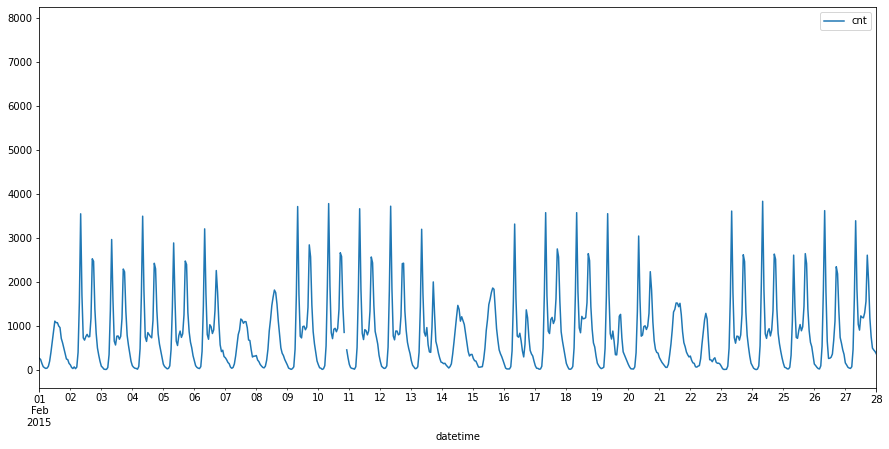

In [18]:
rawData[['cnt']].plot(figsize=(15, 7), xlim=('2015-02-01', '2015-02-28'))
plt.show()

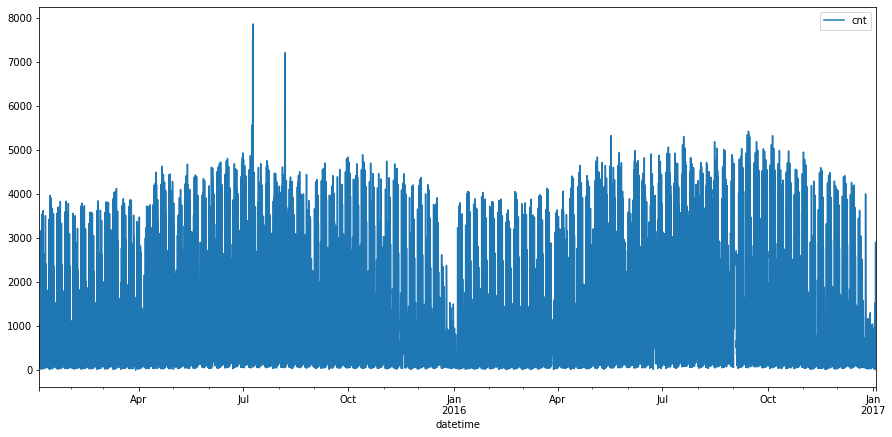

In [19]:
rawData[['cnt']].plot(figsize=(15, 7))
plt.show()

In [20]:
rawData['year'] = rawData.timestamp.dt.year

In [21]:
rawData['month'] = rawData.timestamp.dt.month

In [22]:
rawData['day'] = rawData.timestamp.dt.day

In [23]:
rawData['hour'] = rawData.timestamp.dt.hour

In [24]:
rawData['dayofweek'] = rawData.timestamp.dt.dayofweek

In [25]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek
datetime,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0


In [26]:
rawData['cnt'].shift(1)

datetime
2015-01-04 00:00:00       NaN
2015-01-04 01:00:00     182.0
2015-01-04 02:00:00     138.0
2015-01-04 03:00:00     134.0
2015-01-04 04:00:00      72.0
                        ...  
2017-01-03 19:00:00    2220.0
2017-01-03 20:00:00    1042.0
2017-01-03 21:00:00     541.0
2017-01-03 22:00:00     337.0
2017-01-03 23:00:00     224.0
Freq: H, Name: cnt, Length: 17544, dtype: float64

In [27]:
rawData['cnt'].shift(2)

datetime
2015-01-04 00:00:00       NaN
2015-01-04 01:00:00       NaN
2015-01-04 02:00:00     182.0
2015-01-04 03:00:00     138.0
2015-01-04 04:00:00     134.0
                        ...  
2017-01-03 19:00:00    2742.0
2017-01-03 20:00:00    2220.0
2017-01-03 21:00:00    1042.0
2017-01-03 22:00:00     541.0
2017-01-03 23:00:00     337.0
Freq: H, Name: cnt, Length: 17544, dtype: float64

In [28]:
rawData['lag_cnt1'] = rawData['cnt'].shift(1)
rawData['lag_cnt2'] = rawData['cnt'].shift(2)

In [29]:
rawData['lag_cnt1'].fillna(method='bfill', inplace=True)
rawData['lag_cnt2'].fillna(method='bfill', inplace=True)

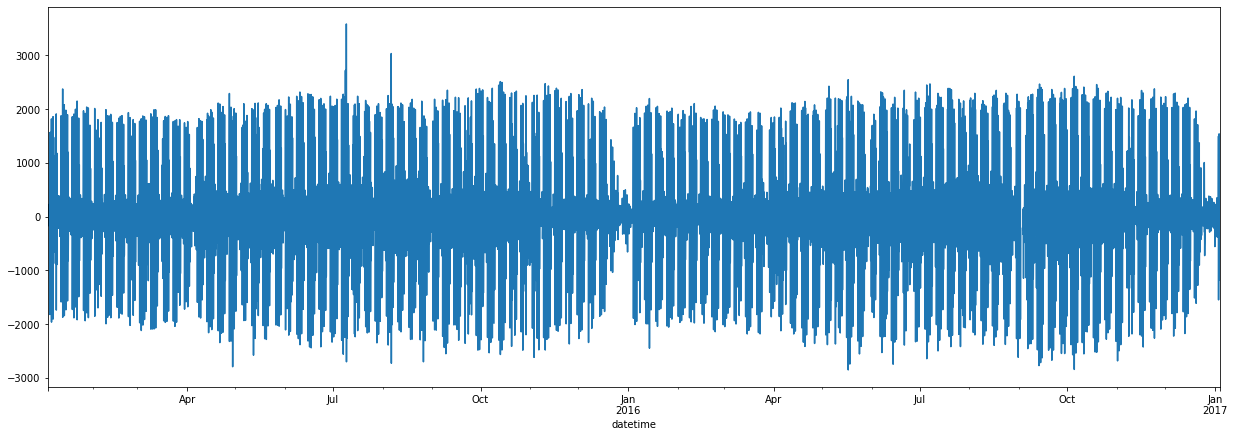

In [30]:
rawData['cnt'].diff().plot(kind='line', figsize=(21, 7))
plt.show()

In [31]:
rawData['diff'] = rawData['cnt'].diff()

In [32]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0,182.0,182.0,NaN
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0,541.0,1042.0,-204.0


In [33]:
rawData['diff'].fillna(method='bfill', inplace=True)

In [34]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0,182.0,182.0,-44.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0,541.0,1042.0,-204.0


In [35]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Freq: H
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  float64       
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  year          17414 non-null  float64       
 11  month         17414 non-null  float64       
 12  day           17414 non-null  float64       
 13  hour          17414 non-null  float64       
 14  dayofweek     17414 non-null  float64      

## Y에 대한 영향이 얼마나 될지 시각적으로 확인 
- 지난번 데이터는 워싱터DC에서 발생한 데이터 였고 
- 런던 바이크 쉐어링 데이터는 어떤 패턴일지 확인 
- 추가적으로 leg count, diff 등의 패턴이 추가되었으므로, 추출된 패턴이 얼마나 영향을 주는지 확인
... 

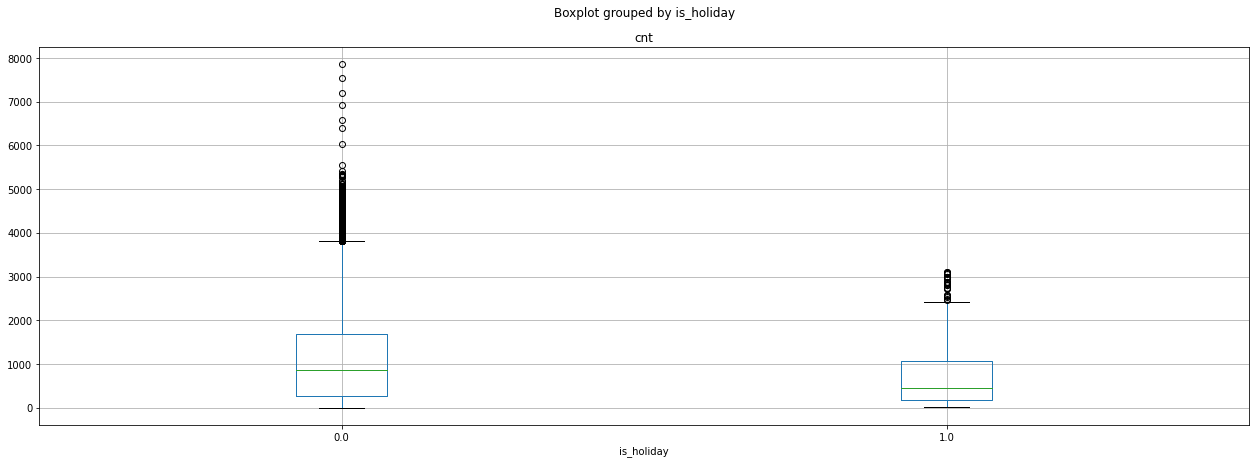

In [36]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='is_holiday', grid=True, figsize=(21,7))
plt.show()

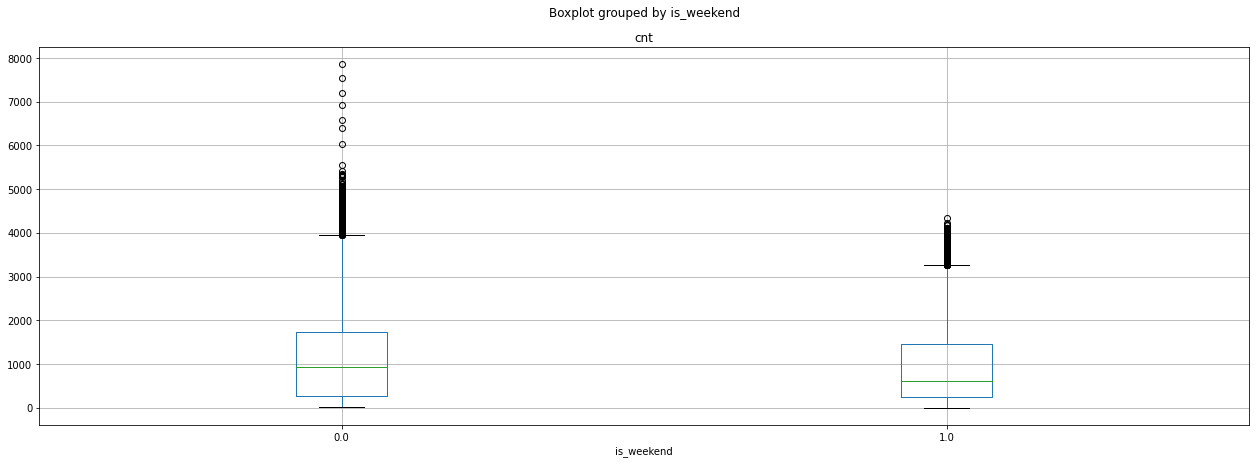

In [37]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='is_weekend', grid=True, figsize=(21,7))
plt.show()

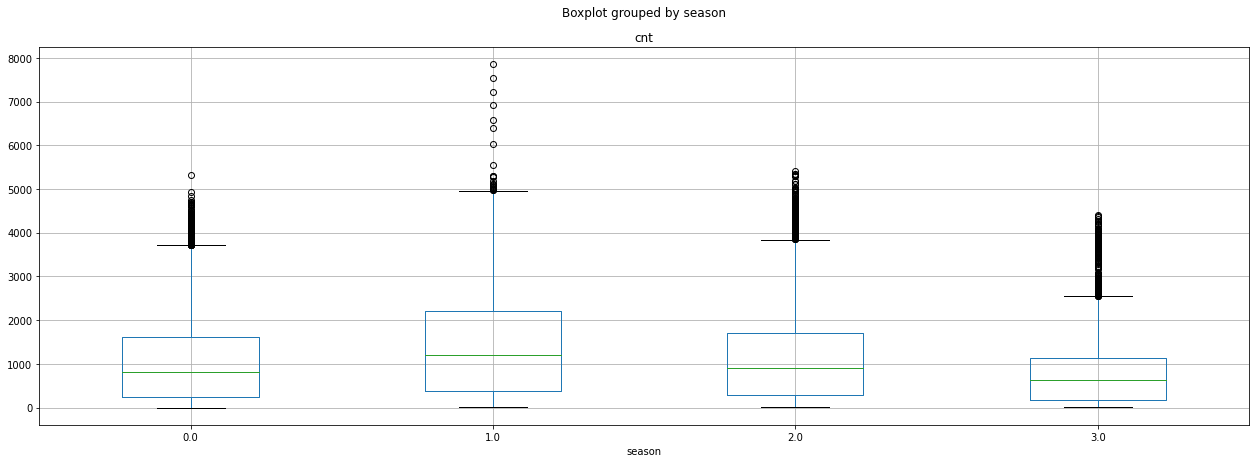

In [38]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='season', grid=True, figsize=(21,7))
plt.show()

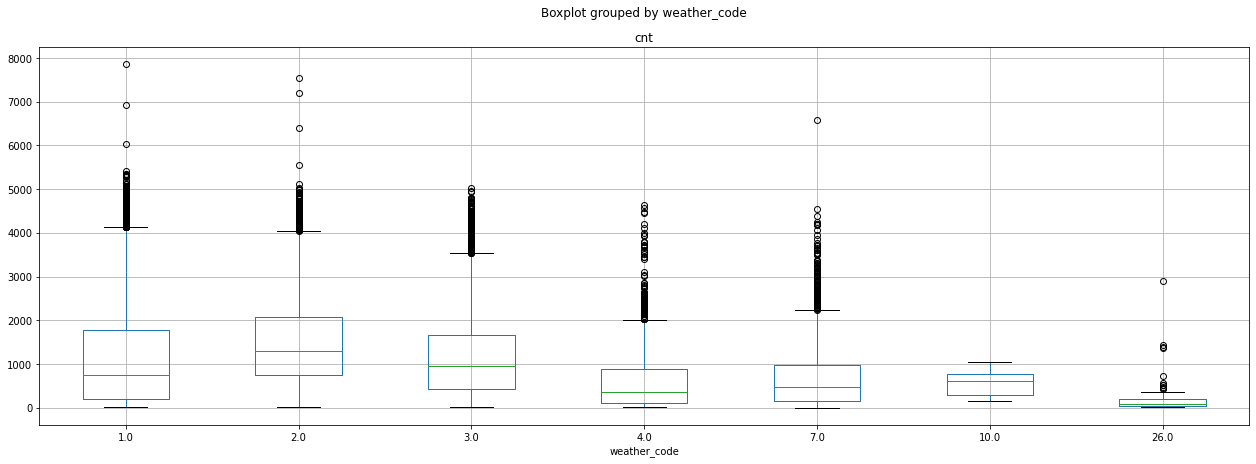

In [39]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='weather_code', grid=True, figsize=(21,7))
plt.show()

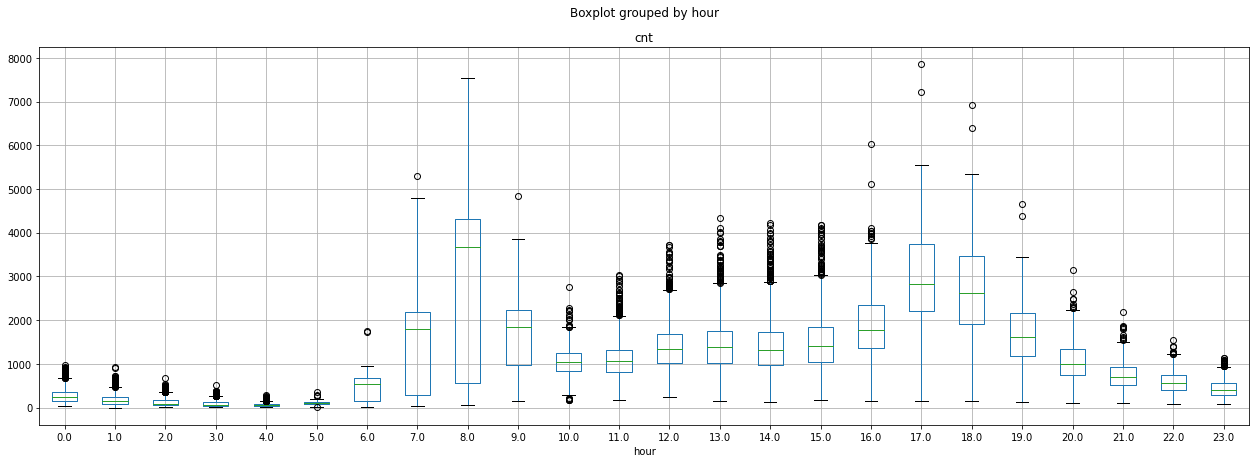

In [40]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='hour', grid=True, figsize=(21,7))
plt.show()

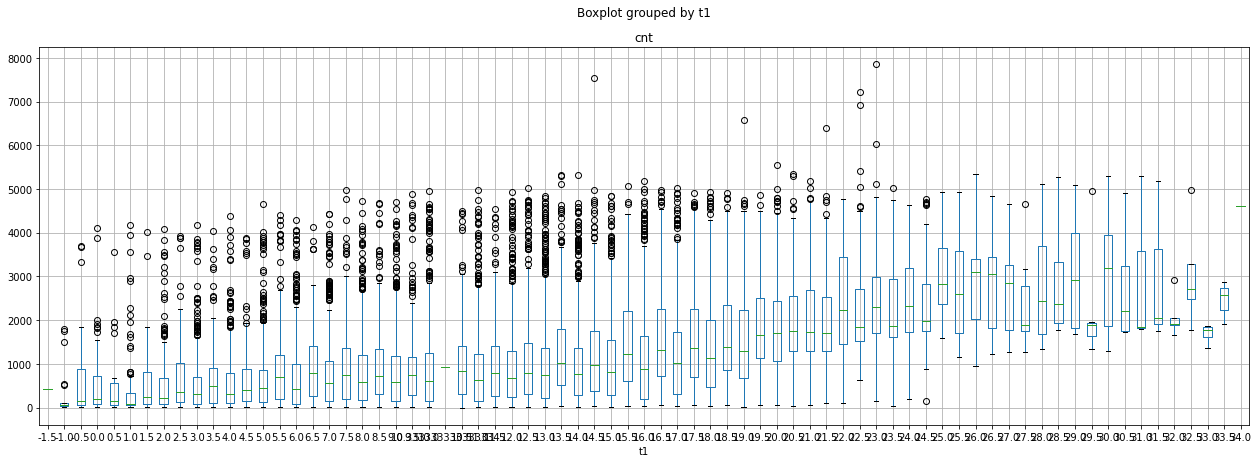

In [41]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='t1', grid=True, figsize=(21,7))
plt.show()

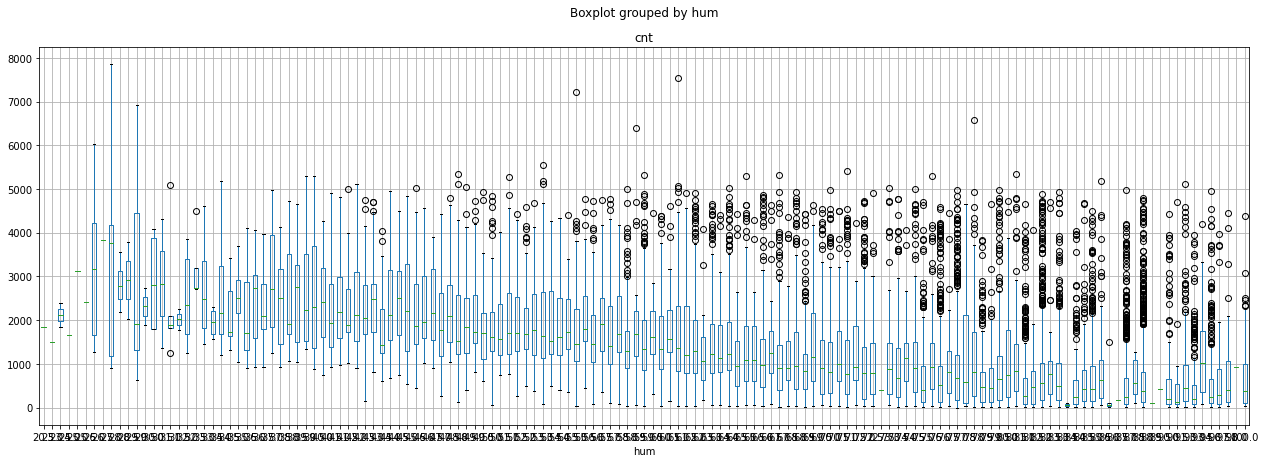

In [42]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='hum', grid=True, figsize=(21,7))
plt.show()

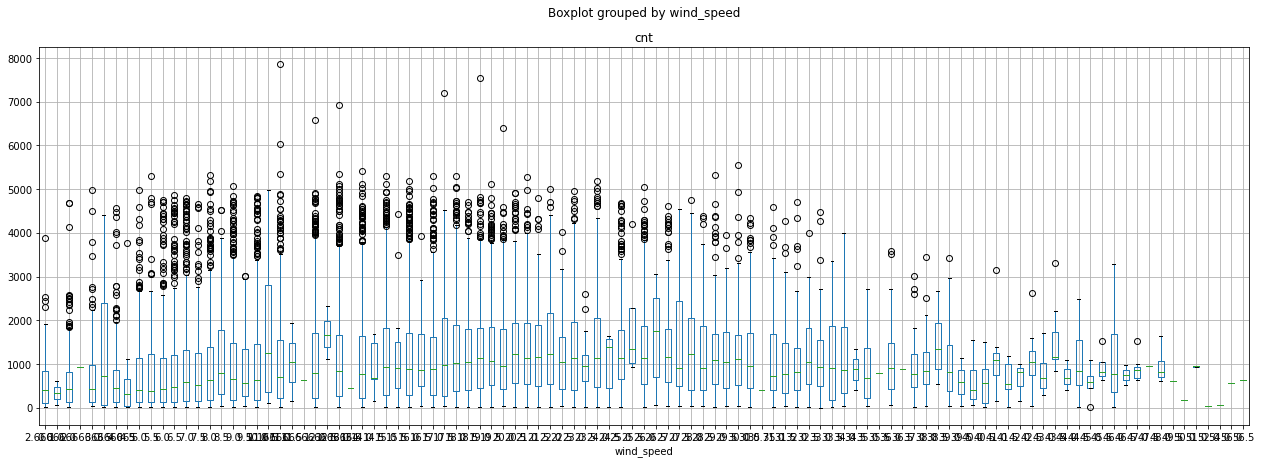

In [43]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='wind_speed', grid=True, figsize=(21,7))
plt.show()

In [44]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0,182.0,182.0,-44.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0,541.0,1042.0,-204.0


In [45]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Freq: H
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  float64       
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  year          17414 non-null  float64       
 11  month         17414 non-null  float64       
 12  day           17414 non-null  float64       
 13  hour          17414 non-null  float64       
 14  dayofweek     17414 non-null  float64      

# 학습/테스트 셋 분리

In [46]:
rawData.dropna(inplace=True, axis=0)

In [47]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  float64       
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  year          17414 non-null  float64       
 11  month         17414 non-null  float64       
 12  day           17414 non-null  float64       
 13  hour          17414 non-null  float64       
 14  dayofweek     17414 non-null  float64       
 15  l

In [48]:
rawTrain = rawData.loc[rawData.index < '2016-08-01', :]
rawTest = rawData.loc[rawData.index >= '2016-08-01', :]
print(rawTrain.shape, rawTest.shape)

(13713, 18) (3701, 18)


In [49]:
x_train = rawTrain.loc[:,'t1':]
y_train = rawTrain[['cnt']]
x_test = rawTest.loc[:, 't1':]
y_test = rawTest[['cnt']]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13713, 16) (13713, 1)
(3701, 16) (3701, 1)


In [50]:
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.495e+06
Date:                Fri, 08 Jan 2021   Prob (F-statistic):                        0.00
Time:                        02:14:32   Log-Likelihood:                         -69025.
No. Observations:               13713   AIC:                                  1.381e+05
Df Residuals:                   13697   BIC:                                  1.382e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
t1               0.2275      0.423      0.537      0.591      -0.603       1.058
t2              -0.2819      0.352     -0.800      0.423      -0.972       0.408
hum             -0.0266      0.032     -0.844      0.398      -0.088       0.035
wind_speed      -0.0878      0.045     -1.944      0.052      -0.176       0.001
weather_code    -0.1689      0.146     -1.154      0.248      -0.456       0.118
is_holiday       0.6170      2.246      0.275      0.784      -3.785       5.019
is_weekend      -1.8141      1.156     -1.570      0.116      -4.079       0.451
season          -0.1433      0.297     -0.482      0.630      -0.726       0.439
year             0.0012      0.002      0.771      0.441      -0.002       0.004
month            0.1544      0.126      1.229      0.219      -0.092       0.401
day             -0.0157      0.036     -0.434      0.665      -0.087       0.055
hour             0.0883      0.054      1.633      0.103      -0.018       0.194
dayofweek        0.5450      0.261      2.090      0.037       0.034       1.056
lag_cnt1         1.0011      0.000   2033.348      0.000       1.000       1.002
lag_cnt2        -0.0023      0.001     -3.928      0.000      -0.003      -0.001
diff             0.9962      0.001   1790.803      0.000       0.995       0.997
==============================================================================
Omnibus:                    27672.771   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1810636499.383
Skew:                         -15.314   Prob(JB):                         0.00
Kurtosis:                    1782.880   Cond. No.                     1.95e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
predict_train = model1.predict(x_train).values
predict_test = model1.predict(x_test).values

In [52]:
predict_train

array([ 138.19994053,  138.57299237,  134.69011409, ..., 1347.37610847,
        971.68846192,  658.71865196])

In [53]:
pd.concat([y_train, pd.DataFrame(predict_train, index=y_train.index, columns=['predict'])], axis=1)

,cnt,predict
datetime,,
2015-01-04 00:00:00,182.0,138.199941
2015-01-04 01:00:00,138.0,138.572992
2015-01-04 02:00:00,134.0,134.690114
2015-01-04 03:00:00,72.0,73.030741
2015-01-04 04:00:00,47.0,48.096345
...,...,...
2016-07-31 19:00:00,2885.0,2885.177083
2016-07-31 20:00:00,2123.0,2124.033076
2016-07-31 21:00:00,1346.0,1347.376108


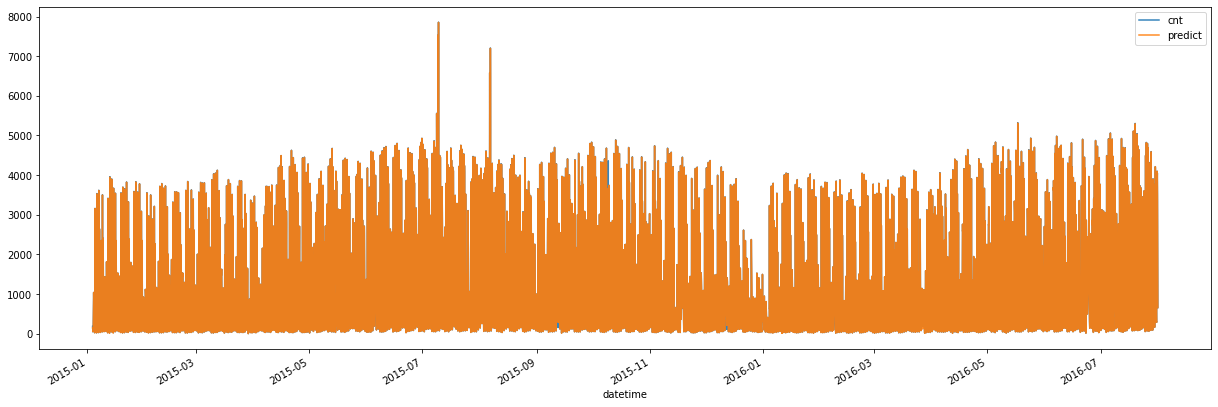

In [54]:
pd.concat([y_train, pd.DataFrame(predict_train, index=y_train.index, columns=['predict'])], axis=1).plot(
    kind='line', figsize=(21,7), alpha=0.9,
    linewidth=1.5
)
plt.show()

In [55]:
((y_train.values.flatten() - predict_train) ** 2).mean()

1379.1652657241889

In [56]:
predict_test

array([371.47218698, 202.28651722, 124.65894371, ..., 336.57248254,
       224.37569965, 140.14632327])

In [57]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1)

,cnt,predict
datetime,,
2016-08-01 00:00:00,372.0,371.472187
2016-08-01 01:00:00,203.0,202.286517
2016-08-01 02:00:00,125.0,124.658944
2016-08-01 03:00:00,79.0,78.909552
2016-08-01 04:00:00,79.0,79.089757
...,...,...
2017-01-03 19:00:00,1042.0,1043.724039
2017-01-03 20:00:00,541.0,539.732926
2017-01-03 21:00:00,337.0,336.572483


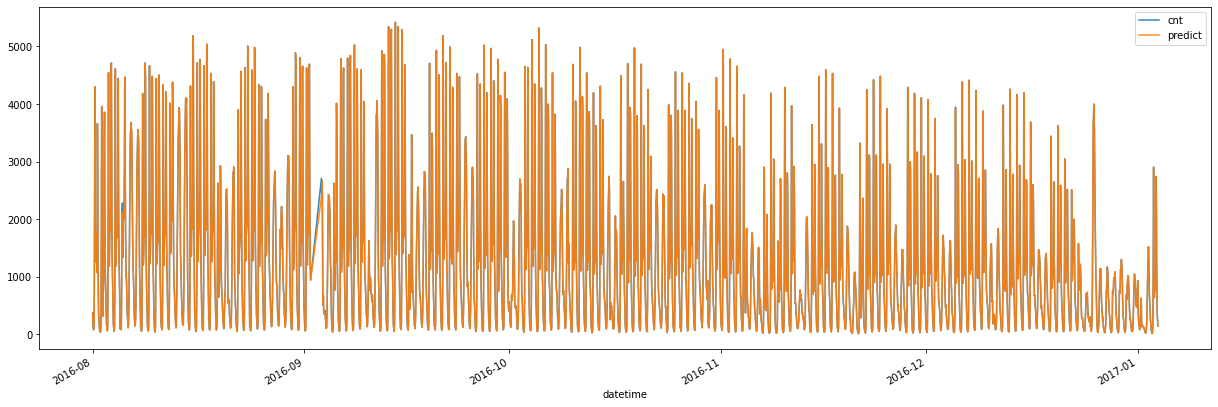

In [58]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1).plot(
    kind='line', figsize=(21,7), alpha=0.9,
    linewidth=1.5
)
plt.show()

In [59]:
mean_absolute_error(y_true=y_test, y_pred=predict_test)

2.5153240622486877

In [60]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0,182.0,182.0,-44.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0,541.0,1042.0,-204.0
